# Opening a Chinese restaurant in London

**Business Problem**: A client from China is exploring the option of opening a restaurant in London. The client is unfortunately not very familiar with London and is only aware of the city having a significant Chinese population. As the client plans to open a traditional restaurant, it's important that the establishment would be in a neighbourhood of notable Chinese population. The client envisages to bring 'home' (the flavours at least) a bit closer to the local Chinese communities by providing truly authentic cuisine.

Although the client is not afraid of some competition, doesn't want to select a neighbourhood that already has a lot of popular Chinese restaurants.

**Data**: The exercise will use four datasets and Foursquare.

* **2011 Census dataset - London**: This dataset contains detailed ethnicity data down to Output Areas (OAs), a level of detail which is not necessary in this case. Instead the research will use Middle Layer Super Output Areas (MSOAs) which is second to boroughs (local authorities). The data can be downloaded from the website of the Office of National Statistics [here](https://www.ons.gov.uk/peoplepopulationandcommunity/populationandmigration/populationestimates/datasets/2011censuskeystatisticsandquickstatisticsforwardsandoutputareasinenglandandwales).
* **Middle Layer Super Output Areas (December 2011) Population Weighted Centroids**: As the dataset above doesn't contain detailed location data, another dataset is needed to find the centroids of the MSOAs. This step will make it possible to use Foursquare to find nearby restaurants. The data can be downloaded from the website of the Office of National Statistics  [here](https://geoportal.statistics.gov.uk/datasets/middle-layer-super-output-areas-december-2011-population-weighted-centroids).
* **Digital Vector Boundaries for Middle Layer Super Output Areas for England and Wales**: Contains the coordinates of shapes that can be used with Folium to visualise the data on a map, it can be found [here](https://geoportal.statistics.gov.uk/datasets/826dc85fb600440889480f4d9dbb1a24_0). It was filtered for London MSAOs outside of Jupyter Nootbook because of performance issues.
* **Land Area and Population Density**: To help filter regions for the right properties, the dataset can be found [here](https://data.london.gov.uk/dataset/super-output-area-population-lsoa-msoa-london).
* **Foursquare**: Last but not least Foursquare location data will help to profile restaurants around the centroids of the selected MSAOs with high Chinese population.

**Methodology**: The research uses exploratory data analysis and k-means clustering to find neighbourhoods with high Chinese population and then k-means clustering once again to group the MSOAs based on restaurant types. For the client an ideal neighbourhood would not only mean it has a few Chinese restaurants but in general Far Eastern restaurants are not super popular.

In [39]:
# import libraries
import pandas as pd
import numpy as np
import folium
import json
import requests
import geopandas
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import branca.colormap as cm
from sklearn.preprocessing import Normalizer

In [ ]:
# adding dotenv to hide keys
%load_ext dotenv
%dotenv

In [40]:
# create a .env file with your credentials

# get api key
client_id = %env CLIENT_ID
cliend_secret = %env CLIENT_SECRET
version = '20191101'

## Loading and formatting datasets
In this section we are doing a bit of data wrangling to make our datasets more suitable for analysis.

In [41]:
# !!! the report doesn't have the data files, download them first and put them into your data folder !!!

# reading in London only census data
census_df = pd.read_excel('data/R2_2_EW__RT__Table_QS211__OA_London_v1.xlsx', 'MSOA', skiprows=9)

# dropping empty column
census_df.drop(census_df.columns[6], axis=1, inplace=True)

# correct column labels are in different rows, extracting the first part
column_names_first = census_df.columns[0:6].tolist()

# extracting the second part
column_names_second = census_df.iloc[0,6:].tolist()

# creating and assigning new column labels
new_column_name = column_names_first + column_names_second
census_df.columns = new_column_name

# dropping redundant rows
census_df.drop([0,1,2], inplace=True)

# resetting index
census_df.reset_index(inplace=True, drop=True)

census_df.head()

,Region code,Region name,Local authority code,Local authority name,MSOA Code,MSOA Name,All categories: Ethnic group (detailed),White: English/Welsh/Scottish/Northern Irish/British,White: Irish,White: Gypsy or Irish Traveller,...,Other ethnic group: Punjabi,Other ethnic group: Somali,Other ethnic group: Somalilander,Other ethnic group: Sri Lankan,Other ethnic group: Tamil,Other ethnic group: Thai,Other ethnic group: Turkish,Other ethnic group: Turkish Cypriot,Other ethnic group: Vietnamese,Other ethnic group: Any other ethnic group
0,E12000007,LONDON,E09000007,Camden,E02000166,Camden 001,7924,4764,317,7,...,0,0,0,0,0,0,4,2,0,51
1,E12000007,LONDON,E09000007,Camden,E02000167,Camden 002,7944,4606,162,7,...,0,0,0,0,0,0,1,0,0,31
2,E12000007,LONDON,E09000007,Camden,E02000168,Camden 003,8172,4879,346,2,...,0,6,0,0,0,1,3,0,1,32
3,E12000007,LONDON,E09000007,Camden,E02000169,Camden 004,7637,3663,174,1,...,0,0,1,0,0,0,4,0,0,48
4,E12000007,LONDON,E09000007,Camden,E02000170,Camden 005,8338,4041,336,2,...,0,5,0,0,0,0,2,0,0,39


In [42]:
# checking for relevant columns by searching for 'chinese' in headings
chinese_columns = [col for col in census_df.columns if 'chinese' in col.lower()]

# creating new dataset with relevant columns
cn_df = census_df[['MSOA Code', 'MSOA Name', 'All categories: Ethnic group (detailed)'] + chinese_columns]

# extracting new column names as it's easier to read them from a list
cn_columns = cn_df.columns.tolist()

# adding up Chinese related ethnic groups
cn_df['Chinese Population'] = cn_df[cn_columns[3]] + cn_df[cn_columns[4]] + cn_df[cn_columns[5]] + cn_df[cn_columns[6]]

# keep necessary rows
cn_df = cn_df.drop(columns = [cn_columns[3], cn_columns[4], cn_columns[5], cn_columns[6]])

# rename columns
cn_df.rename(columns={'All categories: Ethnic group (detailed)': 'Total'}, inplace=True)

# total population / chinese population
print(cn_df[['Total', 'Chinese Population']].sum())
cn_df.head()


Total                 8173941.0
Chinese Population     129108.0
dtype: float64


,MSOA Code,MSOA Name,Total,Chinese Population
0,E02000166,Camden 001,7924,83
1,E02000167,Camden 002,7944,137
2,E02000168,Camden 003,8172,72
3,E02000169,Camden 004,7637,177
4,E02000170,Camden 005,8338,155


In [43]:
# # API call for population weighted centroids
# response = requests.get("https://opendata.arcgis.com/datasets/b0a6d8a3dc5d4718b3fd62c548d60f81_0.geojson")

# # Read json
# lon_geojson = json.loads(response.text)

# open the downloaded file for MSOA population weighted centroids of the UK
with open("data/Middle_Layer_Super_Output_Areas__December_2011__Population_Weighted_Centroids.geojson", "r") as read_file:
    centroids_df = json.load(read_file)

# getting London MSOA codes to filter centroids
london_msoas = cn_df['MSOA Code'].values.tolist()

# filter centroids for London MSOAs
london_centroids_df = pd.DataFrame([(x['properties']['msoa11cd'], 
                               x['geometry']['coordinates'][1],
                               x['geometry']['coordinates'][0]) for x in centroids_df['features'] if x['properties']['msoa11cd'] in london_msoas])

# renaming columns
london_centroids_df.columns = ['MSOA Code', 'Latitude', 'Longitude']
london_centroids_df.head()


,MSOA Code,Latitude,Longitude
0,E02000246,51.535363,-0.395945
1,E02000247,51.533821,-0.369571
2,E02000244,51.536529,-0.327992
3,E02000242,51.540434,-0.311618
4,E02000243,51.537928,-0.346903


In [44]:
# let's add the population weighted centroids to our dataframe
cn_centroids_df = pd.merge(cn_df, london_centroids_df, on='MSOA Code')

# loading in the dataset containing the area sq km of the MSOAs
msoa_areas = pd.read_excel("data/land-area-population-density-lsoa11-msoa11.xlsx", usecols=(0,5))

# merging the datasets
final_pop_df = pd.merge(cn_centroids_df, msoa_areas, left_on='MSOA Code', right_on='MSOA11 Code').drop(columns='MSOA11 Code')

final_pop_df.head()

,MSOA Code,MSOA Name,Total,Chinese Population,Latitude,Longitude,Area Sq Km
0,E02000166,Camden 001,7924,83,51.562958,-0.147053,3.0239
1,E02000167,Camden 002,7944,137,51.557260,-0.173302,2.0813
2,E02000168,Camden 003,8172,72,51.555674,-0.141545,0.6806
3,E02000169,Camden 004,7637,177,51.556033,-0.186380,1.1226
4,E02000170,Camden 005,8338,155,51.553458,-0.199960,0.7713


## Initial exploratory data analysis
Now that we have all the required data in one dataframe, let's explore it a bit and do some initial analysis
- First, let's run panda's describe function to get an overall grip of our data. This is quite a useful step because we want to do a histogram to see the distribution of the data and it greatly helps to identify the most appropriate bin size and tick frequency.
- Then, let's put the data on a map and visually see the distribution of the Chinese population.

In [45]:
final_pop_df.iloc[:,2:4].astype('int').describe().round(1)

,Total,Chinese Population
count,983.0,983.0
mean,8315.3,131.3
std,1448.4,110.1
min,5184.0,3.0
25%,7337.5,67.0
50%,8156.0,101.0
75%,9110.0,157.0
max,14719.0,1203.0


In [46]:
final_pop_df.iloc[:,2:4].astype('int').sum()

Total                 8173941
Chinese Population     129108
dtype: int64

Text(0.5, 1.0, 'Histogram of Chinese population in MSOAs')

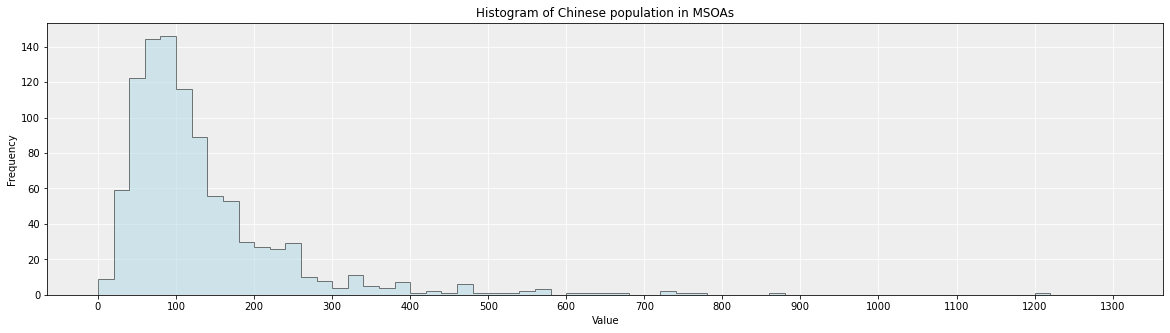

In [47]:
# show histogram
fig, ax = plt.subplots(1, figsize=(20,5))
ax.set_xticks(np.arange(0, final_pop_df['Chinese Population'].max()+100, 100))
n, bins, patches = ax.hist(x=final_pop_df['Chinese Population'], 
                            histtype='stepfilled', 
                            fc='lightblue', 
                            ec='black', 
                            bins=np.arange(0, final_pop_df['Chinese Population'].max()+100, 20), 
                            alpha=0.5, 
                            zorder=3)
ax.grid(color='white', linestyle='solid', zorder=0)
ax.set_facecolor('#EEEEEE')
ax.set_xlabel('Value')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of Chinese population in MSOAs')

In [48]:
# This code filters the Boundaries geojson file only for London MSOAs
# Don't run it in Jupyter, this is just an example how it would work in this enviroment
# Use the convert.py

# # MSOA codes
# london_msoa = final_pop_df['MSOA Code'].values.tolist()

# # MSOA geojson
# response = requests.get("https://opendata.arcgis.com/datasets/826dc85fb600440889480f4d9dbb1a24_0.geojson")

# # Read json
# uk_geojson = json.loads(response.text)

# # Filter for London MSOAs
# lon_geojson = [x for x in uk_geojson.features if x['properties']['msoa11cd'] in london_msoa]

# with open('lon_geojson.json', 'w') as write_file:
#     json.dump(lon_geojson, write_file)

In [ ]:
# visualising Chinese population in London

# !!! download the geojson file and run the convert.py to generate the lon_geojson.json !!!

# use geopandas to load geojson data as later we will need to amend it
lon_geojson = geopandas.read_file('data/lon_geojson.json')

# getting coordinates for London
geolocator = Nominatim(user_agent="cn_london")
location = geolocator.geocode("London")

# creating map
m = folium.Map(location=[location.latitude, location.longitude], tiles='cartodbpositron', zoom_start=11)

# choropleth map for population density in MSOAs
folium.Choropleth(
    geo_data=lon_geojson.to_json(),
    name='Choropleth',
    data=final_pop_df,
    columns=['MSOA Code', 'Chinese Population'],
    key_on='feature.properties.msoa11cd',
    fill_color='YlGn',
    fill_opacity=0.8,
    line_opacity=0.2,
    nan_fill_color='grey',
    nan_fill_opacity=0.4,
    legend_name='Population'
).add_to(m)
m

<img src="maps/MSOA.png">

## Clustering MSOAs to find local population centroids
Using the choropleth map we can easily identify a few population centres but it would be a somewhat biased selection of MSOAs. Furthermore, as the catchment area of a restaurant is probably bigger than an MSOA, it would be nice to cluster them together based on some parameters. Without thoroughly checking what the literature has to say about restaurant catchment areas, I chose a 2000m radius (12.57 sq km) from the population centroid and at least 2000 headcount of Chinese origin.

In [49]:
# kmeans function to determine cluster size 
def optimal_cluster(start_cluster, end_cluster, data, weight):
    result = {}
    for i in range(start_cluster, end_cluster):
        kmeans = KMeans(n_clusters=i, random_state=10).fit(data, sample_weight=weight)
        final_pop_df["Population Cluster"] = kmeans.labels_
    
        # sum of Chinese population and area sq km
        cluster_denisty = final_pop_df.groupby(['Population Cluster']).agg({'Chinese Population': 'sum', 'Area Sq Km': 'sum'})

        # number of clusters with desired outcome
        no_cluster = cluster_denisty[(cluster_denisty['Area Sq Km'] < 12.57) & (cluster_denisty['Chinese Population'] >= 2000)].shape[0]
        
        result[i] = no_cluster
        
    return result

In [50]:
# kmeans preparation
X = final_pop_df[['Latitude', 'Longitude']].to_numpy()
pop_weight = final_pop_df['Chinese Population'].to_numpy()

# run optimal cluster function
result = pd.DataFrame.from_dict(data=optimal_cluster(1, 200, X, pop_weight), orient='index', columns=['N filtered cluster'])

Text(0.5, 1.0, 'K-means ideal cluster size')

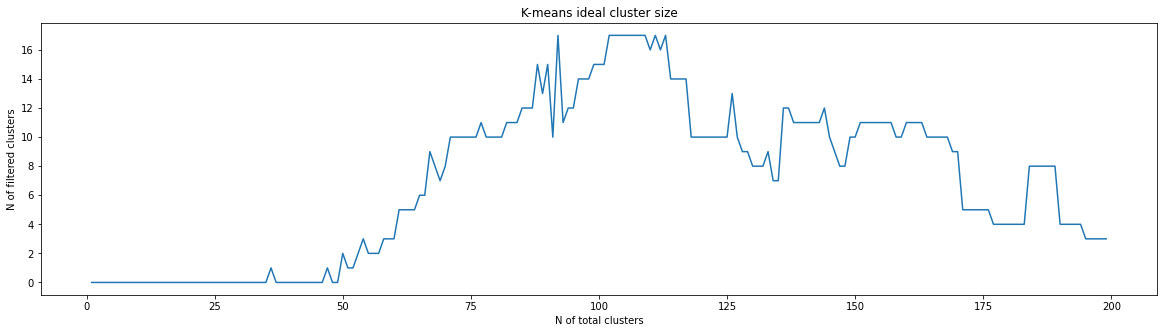

In [51]:
# show plot of cluster size
fig, ax = plt.subplots(1, figsize=(20,5))
ax.set_yticks(np.arange(0, result['N filtered cluster'].max() + 1, 2))
ax.plot(result)
ax.set_xlabel('N of total clusters')
ax.set_ylabel('N of filtered clusters')
ax.set_title('K-means ideal cluster size')

In [52]:
# show max corresponding clusters out of total clusters
result[result['N filtered cluster'] == result['N filtered cluster'].max()]

,N filtered cluster
92,17
102,17
103,17
104,17
105,17
106,17
107,17
108,17
109,17
111,17


In [53]:
# Let's go with 92 for this model
kmeans = KMeans(n_clusters=92, random_state=10).fit(X, sample_weight=pop_weight)

# adding our labels back to our dataframe
final_pop_df["Population Cluster"] = kmeans.labels_
final_pop_df.head()

,MSOA Code,MSOA Name,Total,Chinese Population,Latitude,Longitude,Area Sq Km,Population Cluster
0,E02000166,Camden 001,7924,83,51.562958,-0.147053,3.0239,72
1,E02000167,Camden 002,7944,137,51.557260,-0.173302,2.0813,72
2,E02000168,Camden 003,8172,72,51.555674,-0.141545,0.6806,12
3,E02000169,Camden 004,7637,177,51.556033,-0.186380,1.1226,72
4,E02000170,Camden 005,8338,155,51.553458,-0.199960,0.7713,86


In [54]:
# sum of Chinese population and area sq km
cluster_denisty = final_pop_df.groupby(['Population Cluster']).agg({'Chinese Population': 'sum', 'Area Sq Km': 'sum'})

# labels for filtering for the above given desired parameters
map_labels = cluster_denisty[(cluster_denisty['Area Sq Km'] < 12.57) & (cluster_denisty['Chinese Population'] >= 2000)]

# filterting dataset
filtered_df = final_pop_df[final_pop_df['Population Cluster'].isin(map_labels.index.tolist())]

### Showing our filtered clusters on a map
Now that we have our Chinese population clusters, it would be ideal to see them on a map. To this end we need to calculate the total population of a cluster and to merge the MSOAs polygons into a multipolygon - geopandas will be a great asset for this.

In [55]:
# calculating the sum Chinese population for a cluster
filtered_sum_df = filtered_df.groupby('Population Cluster')[['Chinese Population']].sum().reset_index()

# adding cluster number to geojson file
lon_geojson_cluster = pd.merge(filtered_df[['MSOA Code', 'Population Cluster']], lon_geojson, left_on='MSOA Code', right_on='msoa11cd') \
                        .drop(columns=['MSOA Code']) \
                        .rename(columns={'Population Cluster': 'cluster'})

lon_geojson_dissolved = geopandas.GeoDataFrame(lon_geojson_cluster, geometry='geometry').dissolve(by='cluster', as_index=False)


In [ ]:
# creating map
m = folium.Map(location=[location.latitude, location.longitude],
              tiles='cartodbpositron',
              zoom_start=11)

# show MSOAs
folium.GeoJson(
    lon_geojson.to_json(),
    name='MOAs',
    style_function = lambda x: 
        {'color': '#000000',
         'weight': 0.3,
         'opacity': 0.5,
         'fillColor': 'lightgrey',
         'fillOpacity': 0.2}
).add_to(m)

# choropleth map for population density in MSOAs
folium.Choropleth(
    geo_data=lon_geojson_dissolved.to_json(),
    name='Choropleth',
    data=filtered_sum_df,
    columns=['Population Cluster', 'Chinese Population'],
    key_on='feature.properties.cluster',
    fill_color='YlGn',
    fill_opacity=0.8,
    line_opacity=0.2,
    legend_name='Population'
).add_to(m)
    
folium.LayerControl().add_to(m)
m

<img src="maps/Clustered_MSOAs.png">

### Venue data
Our map neatly shows the regions of London that have the desired attributes and also we can see which of these regions have higher Chinese population. The next step is to use the centroids of these regions to get the most popular venues around those centroids - just to note that when using fourthsquare, we are giving a radius thus the search area won't totally overlap the region clusters.

In [56]:
# first, let's create a new dataframe with the cluster labels and the coordinates of the centroids

# getting centroids
centroids = kmeans.cluster_centers_

# creating new dataframe
clusters_df = filtered_sum_df.apply(lambda x: pd.Series({'Population Cluster': x['Population Cluster'], 'Latitude': centroids[x['Population Cluster']][0], 'Longitude': centroids[x['Population Cluster']][1], 'Chinese Population': x['Chinese Population']}), axis=1)
clusters_df.head()

,Population Cluster,Latitude,Longitude,Chinese Population
0,10.0,51.531015,-0.070671,2272.0
1,12.0,51.557027,-0.118661,2858.0
2,17.0,51.595919,-0.248091,2502.0
3,25.0,51.519614,-0.174481,2401.0
4,27.0,51.496689,-0.019123,4815.0


In [57]:
# now we need to create a function to get the most popular venues around the centroids

# first, this function return the api call url
def return_url(client_id, cliend_secret, version, lat, lng, cat_id, offset=0):
    return 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}&offset={}'.format(
        client_id, cliend_secret, version, lat, lng, cat_id, 2000, 50, offset)

# then, the second function returns the venues per cluster
def get_venues(cluster, client_id, cliend_secret, version, lat, lng, cat_id):

        # checks the total number for the cluster to loop through afterwards
        total_results = requests.get(return_url(client_id, cliend_secret, version, lat, lng, cat_id)).json()['response']['totalResults']

        # the venues will be captured in an array, the first number being the cluster number and then the venue type
        cluster_venues = []

        for cycle in range(0, total_results, 50):
                offset = cycle

                venues = requests.get(return_url(client_id, cliend_secret, version, lat, lng, cat_id, offset)).json()['response']['groups'][0]['items']
                for venue in venues:
                        cluster_venues.append([cluster, venue['venue']['categories'][0]['name']])

        return cluster_venues


In [59]:
# category id for resturants
cat_id = '4d4b7105d754a06374d81259'

# running the function for each cluster
total_venues = []
for cluster in clusters_df[['Population Cluster', 'Latitude', 'Longitude']].to_numpy():
    venues = get_venues(cluster[0], client_id, cliend_secret, version, cluster[1], cluster[2], cat_id)
    total_venues.extend(venues)


In [60]:
# creating a new dataframe for the venues
venue_df = pd.DataFrame(total_venues)
venue_crosstab = pd.crosstab(venue_df[0], venue_df[1])

# let's drop a few venue types
venue_crosstab.drop(['Café', 'Restaurant', 'Bakery', 'Deli / Bodega', 'Sandwich Place'], axis=1, inplace=True)
venue_crosstab.index.name = 'Population Cluster'
venue_crosstab

1,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,BBQ Joint,Bagel Shop,...,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint,Xinjiang Restaurant
Population Cluster,,,,,,,,,,,,,,,,,,,,,
10.0,0,0,0,2,1,1,0,0,2,3,...,1,1,3,0,4,1,3,7,1,0
12.0,0,0,0,0,0,1,0,0,0,0,...,0,4,5,0,3,0,4,4,0,0
17.0,0,0,0,0,0,2,0,0,0,1,...,0,0,1,0,1,0,0,1,1,0
25.0,0,1,2,0,3,3,1,1,0,1,...,0,0,3,0,4,0,2,0,0,0
27.0,0,0,4,0,3,3,1,0,0,0,...,0,1,3,0,3,0,0,7,0,0
29.0,0,0,1,0,1,3,0,0,2,1,...,0,3,5,0,1,0,0,2,0,0
31.0,0,1,2,0,3,7,1,0,1,1,...,0,4,4,0,4,0,1,2,0,0
54.0,1,0,0,1,1,4,0,1,1,1,...,0,3,5,0,4,1,2,12,0,0
58.0,0,1,2,0,1,3,1,0,0,0,...,0,3,3,0,4,0,2,5,1,0


In [61]:
# checking the venue types, we notice that there are several types of Chinese resturants. Therefore we get the complete venue list from fourthsquare and filter it for Chinese restaurant types
master_venues = requests.get('https://api.foursquare.com/v2/venues/categories?&client_id={}&client_secret={}&v={}'.format(
        client_id, cliend_secret, version)).json()['response']

chinese_restaurant = '4bf58dd8d48988d145941735'
asian_restaurant = '4bf58dd8d48988d142941735'
chinese_restaurant = '4bf58dd8d48988d145941735'
restaurant_categories = [x for x in master_venues['categories'] if cat_id == x['id']]
asian_categories = [x for x in restaurant_categories[0]['categories'] if asian_restaurant == x['id']]
chinese_categories = [x['name'] for x in [x for x in asian_categories[0]['categories'] if chinese_restaurant == x['id']][0]['categories']]

# and then merge all into chinese restaurants
for restaurant in chinese_categories:
    try:
        venue_crosstab['Chinese Restaurant'] = venue_crosstab['Chinese Restaurant'] + venue_crosstab[restaurant]
        venue_crosstab.drop(columns=[restaurant])
    except:
        pass

In [62]:
# now let's check which are the most common venue types around the centroids of each region

# function to return most common venues
def return_most_common_venues(row, num_top_venues):
    row_categories_sorted = row.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

# top 10 venues for each neighborhood
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = []
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Popular Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Popular Venue'.format(ind+1))

top_venues_sorted = pd.DataFrame(columns=columns)
top_venues_sorted['Population Cluster'] = venue_crosstab.index

# create a new dataframe
for ind in np.arange(venue_crosstab.shape[0]):
    top_venues_sorted.iloc[ind, :num_top_venues] = return_most_common_venues(venue_crosstab.iloc[ind], num_top_venues)

top_venues_sorted.set_index(['Population Cluster'], inplace=True)
top_venues_sorted

,1st Most Popular Venue,2nd Most Popular Venue,3rd Most Popular Venue,4th Most Popular Venue,5th Most Popular Venue,6th Most Popular Venue,7th Most Popular Venue,8th Most Popular Venue,9th Most Popular Venue,10th Most Popular Venue
Population Cluster,,,,,,,,,,
10.0,Italian Restaurant,Pizza Place,Burger Joint,Vietnamese Restaurant,Indian Restaurant,Middle Eastern Restaurant,Chinese Restaurant,Breakfast Spot,Gastropub,Turkish Restaurant
12.0,Italian Restaurant,Pizza Place,Indian Restaurant,Thai Restaurant,Ethiopian Restaurant,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Tapas Restaurant,Bistro,Kebab Restaurant
17.0,Chinese Restaurant,Fast Food Restaurant,Indian Restaurant,Korean Restaurant,Japanese Restaurant,Italian Restaurant,Sushi Restaurant,Asian Restaurant,Fried Chicken Joint,Thai Restaurant
25.0,Italian Restaurant,French Restaurant,Pizza Place,Burger Joint,Middle Eastern Restaurant,Lebanese Restaurant,Persian Restaurant,Chinese Restaurant,Greek Restaurant,Gastropub
27.0,Italian Restaurant,Pizza Place,Fast Food Restaurant,Indian Restaurant,Burger Joint,Vietnamese Restaurant,Chinese Restaurant,English Restaurant,Sushi Restaurant,American Restaurant
29.0,Italian Restaurant,Pizza Place,French Restaurant,Japanese Restaurant,Indian Restaurant,Burger Joint,Gastropub,English Restaurant,Middle Eastern Restaurant,Thai Restaurant
31.0,Italian Restaurant,Indian Restaurant,Asian Restaurant,Pizza Place,Burger Joint,Chinese Restaurant,Portuguese Restaurant,Seafood Restaurant,French Restaurant,Sushi Restaurant
54.0,Italian Restaurant,Pizza Place,Vietnamese Restaurant,Burger Joint,French Restaurant,Gastropub,Japanese Restaurant,Steakhouse,Food Truck,Indian Restaurant
58.0,Pizza Place,Indian Restaurant,Italian Restaurant,Vietnamese Restaurant,English Restaurant,Breakfast Spot,Fast Food Restaurant,Chinese Restaurant,French Restaurant,Turkish Restaurant


In [63]:
# now we are ready to cluster our regions based on the venues
X = venue_crosstab.to_numpy()

kmeans = KMeans(n_clusters=4, random_state=10).fit(X)

# adding back the clusters
top_venues_sorted['Venue Cluster'] = kmeans.labels_
top_venues_sorted


,1st Most Popular Venue,2nd Most Popular Venue,3rd Most Popular Venue,4th Most Popular Venue,5th Most Popular Venue,6th Most Popular Venue,7th Most Popular Venue,8th Most Popular Venue,9th Most Popular Venue,10th Most Popular Venue,Venue Cluster
Population Cluster,,,,,,,,,,,
10.0,Italian Restaurant,Pizza Place,Burger Joint,Vietnamese Restaurant,Indian Restaurant,Middle Eastern Restaurant,Chinese Restaurant,Breakfast Spot,Gastropub,Turkish Restaurant,3
12.0,Italian Restaurant,Pizza Place,Indian Restaurant,Thai Restaurant,Ethiopian Restaurant,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Tapas Restaurant,Bistro,Kebab Restaurant,3
17.0,Chinese Restaurant,Fast Food Restaurant,Indian Restaurant,Korean Restaurant,Japanese Restaurant,Italian Restaurant,Sushi Restaurant,Asian Restaurant,Fried Chicken Joint,Thai Restaurant,0
25.0,Italian Restaurant,French Restaurant,Pizza Place,Burger Joint,Middle Eastern Restaurant,Lebanese Restaurant,Persian Restaurant,Chinese Restaurant,Greek Restaurant,Gastropub,2
27.0,Italian Restaurant,Pizza Place,Fast Food Restaurant,Indian Restaurant,Burger Joint,Vietnamese Restaurant,Chinese Restaurant,English Restaurant,Sushi Restaurant,American Restaurant,3
29.0,Italian Restaurant,Pizza Place,French Restaurant,Japanese Restaurant,Indian Restaurant,Burger Joint,Gastropub,English Restaurant,Middle Eastern Restaurant,Thai Restaurant,1
31.0,Italian Restaurant,Indian Restaurant,Asian Restaurant,Pizza Place,Burger Joint,Chinese Restaurant,Portuguese Restaurant,Seafood Restaurant,French Restaurant,Sushi Restaurant,3
54.0,Italian Restaurant,Pizza Place,Vietnamese Restaurant,Burger Joint,French Restaurant,Gastropub,Japanese Restaurant,Steakhouse,Food Truck,Indian Restaurant,1
58.0,Pizza Place,Indian Restaurant,Italian Restaurant,Vietnamese Restaurant,English Restaurant,Breakfast Spot,Fast Food Restaurant,Chinese Restaurant,French Restaurant,Turkish Restaurant,3


In [64]:
# let's create our final dataframe by adding the coordinates of the centroids, the number of Chinese restaurants and the Chinese population
final_table = pd.merge(clusters_df, top_venues_sorted, on='Population Cluster') \
    .merge(venue_crosstab['Chinese Restaurant'], on='Population Cluster') \
    .sort_values(by=['Venue Cluster'])

final_table

,Population Cluster,Latitude,Longitude,Chinese Population,1st Most Popular Venue,2nd Most Popular Venue,3rd Most Popular Venue,4th Most Popular Venue,5th Most Popular Venue,6th Most Popular Venue,7th Most Popular Venue,8th Most Popular Venue,9th Most Popular Venue,10th Most Popular Venue,Venue Cluster,Chinese Restaurant
16,90.0,51.469918,-0.075850,2175.0,Chinese Restaurant,Pizza Place,Gastropub,Italian Restaurant,Fast Food Restaurant,Fried Chicken Joint,Indian Restaurant,Fish & Chips Shop,Burger Joint,Middle Eastern Restaurant,0,11
2,17.0,51.595919,-0.248091,2502.0,Chinese Restaurant,Fast Food Restaurant,Indian Restaurant,Korean Restaurant,Japanese Restaurant,Italian Restaurant,Sushi Restaurant,Asian Restaurant,Fried Chicken Joint,Thai Restaurant,0,5
15,87.0,51.520744,-0.026784,2486.0,Pizza Place,Italian Restaurant,Fried Chicken Joint,Burger Joint,Chinese Restaurant,Indian Restaurant,Fast Food Restaurant,English Restaurant,Turkish Restaurant,Portuguese Restaurant,0,6
11,69.0,51.475223,-0.035682,3333.0,Chinese Restaurant,Pizza Place,Vietnamese Restaurant,Gastropub,Indian Restaurant,Italian Restaurant,Fish & Chips Shop,Turkish Restaurant,Fast Food Restaurant,Food Truck,0,7
5,29.0,51.488689,-0.173916,2542.0,Italian Restaurant,Pizza Place,French Restaurant,Japanese Restaurant,Indian Restaurant,Burger Joint,Gastropub,English Restaurant,Middle Eastern Restaurant,Thai Restaurant,1,5
7,54.0,51.531389,-0.102945,3189.0,Italian Restaurant,Pizza Place,Vietnamese Restaurant,Burger Joint,French Restaurant,Gastropub,Japanese Restaurant,Steakhouse,Food Truck,Indian Restaurant,1,2
9,59.0,51.491664,-0.201069,4004.0,Italian Restaurant,Pizza Place,Indian Restaurant,Gastropub,Burger Joint,Thai Restaurant,Middle Eastern Restaurant,Mediterranean Restaurant,French Restaurant,Japanese Restaurant,1,1
3,25.0,51.519614,-0.174481,2401.0,Italian Restaurant,French Restaurant,Pizza Place,Burger Joint,Middle Eastern Restaurant,Lebanese Restaurant,Persian Restaurant,Chinese Restaurant,Greek Restaurant,Gastropub,2,6
10,61.0,51.523149,-0.132522,4703.0,Burger Joint,French Restaurant,Italian Restaurant,Pizza Place,Steakhouse,Indian Restaurant,Seafood Restaurant,Chinese Restaurant,English Restaurant,Spanish Restaurant,2,8
14,86.0,51.534714,-0.196027,2253.0,Pizza Place,Italian Restaurant,Indian Restaurant,Middle Eastern Restaurant,Thai Restaurant,Japanese Restaurant,Fast Food Restaurant,French Restaurant,Chinese Restaurant,Burger Joint,3,5


In [65]:
# to highlight the Chinese restaurants in our table

def highlight_cn(val):
    color = 'magenta' if val == 'Chinese Restaurant' else ''
    return 'color: %s' % color

final_table.style.applymap(highlight_cn)

,Population Cluster,Latitude,Longitude,Chinese Population,1st Most Popular Venue,2nd Most Popular Venue,3rd Most Popular Venue,4th Most Popular Venue,5th Most Popular Venue,6th Most Popular Venue,7th Most Popular Venue,8th Most Popular Venue,9th Most Popular Venue,10th Most Popular Venue,Venue Cluster,Chinese Restaurant
16,90.000000,51.469918,-0.075850,2175.000000,Chinese Restaurant,Pizza Place,Gastropub,Italian Restaurant,Fast Food Restaurant,Fried Chicken Joint,Indian Restaurant,Fish & Chips Shop,Burger Joint,Middle Eastern Restaurant,0,11
2,17.000000,51.595919,-0.248091,2502.000000,Chinese Restaurant,Fast Food Restaurant,Indian Restaurant,Korean Restaurant,Japanese Restaurant,Italian Restaurant,Sushi Restaurant,Asian Restaurant,Fried Chicken Joint,Thai Restaurant,0,5
15,87.000000,51.520744,-0.026784,2486.000000,Pizza Place,Italian Restaurant,Fried Chicken Joint,Burger Joint,Chinese Restaurant,Indian Restaurant,Fast Food Restaurant,English Restaurant,Turkish Restaurant,Portuguese Restaurant,0,6
11,69.000000,51.475223,-0.035682,3333.000000,Chinese Restaurant,Pizza Place,Vietnamese Restaurant,Gastropub,Indian Restaurant,Italian Restaurant,Fish & Chips Shop,Turkish Restaurant,Fast Food Restaurant,Food Truck,0,7
5,29.000000,51.488689,-0.173916,2542.000000,Italian Restaurant,Pizza Place,French Restaurant,Japanese Restaurant,Indian Restaurant,Burger Joint,Gastropub,English Restaurant,Middle Eastern Restaurant,Thai Restaurant,1,5
7,54.000000,51.531389,-0.102945,3189.000000,Italian Restaurant,Pizza Place,Vietnamese Restaurant,Burger Joint,French Restaurant,Gastropub,Japanese Restaurant,Steakhouse,Food Truck,Indian Restaurant,1,2
9,59.000000,51.491664,-0.201069,4004.000000,Italian Restaurant,Pizza Place,Indian Restaurant,Gastropub,Burger Joint,Thai Restaurant,Middle Eastern Restaurant,Mediterranean Restaurant,French Restaurant,Japanese Restaurant,1,1
3,25.000000,51.519614,-0.174481,2401.000000,Italian Restaurant,French Restaurant,Pizza Place,Burger Joint,Middle Eastern Restaurant,Lebanese Restaurant,Persian Restaurant,Chinese Restaurant,Greek Restaurant,Gastropub,2,6
10,61.000000,51.523149,-0.132522,4703.000000,Burger Joint,French Restaurant,Italian Restaurant,Pizza Place,Steakhouse,Indian Restaurant,Seafood Restaurant,Chinese Restaurant,English Restaurant,Spanish Restaurant,2,8
14,86.000000,51.534714,-0.196027,2253.000000,Pizza Place,Italian Restaurant,Indian Restaurant,Middle Eastern Restaurant,Thai Restaurant,Japanese Restaurant,Fast Food Restaurant,French Restaurant,Chinese Restaurant,Burger Joint,3,5


In [66]:
# filter for cluster 1
cluster_1 = final_table[(final_table['Venue Cluster'] == 1)]
cluster_1

,Population Cluster,Latitude,Longitude,Chinese Population,1st Most Popular Venue,2nd Most Popular Venue,3rd Most Popular Venue,4th Most Popular Venue,5th Most Popular Venue,6th Most Popular Venue,7th Most Popular Venue,8th Most Popular Venue,9th Most Popular Venue,10th Most Popular Venue,Venue Cluster,Chinese Restaurant
5,29.0,51.488689,-0.173916,2542.0,Italian Restaurant,Pizza Place,French Restaurant,Japanese Restaurant,Indian Restaurant,Burger Joint,Gastropub,English Restaurant,Middle Eastern Restaurant,Thai Restaurant,1,5
7,54.0,51.531389,-0.102945,3189.0,Italian Restaurant,Pizza Place,Vietnamese Restaurant,Burger Joint,French Restaurant,Gastropub,Japanese Restaurant,Steakhouse,Food Truck,Indian Restaurant,1,2
9,59.0,51.491664,-0.201069,4004.0,Italian Restaurant,Pizza Place,Indian Restaurant,Gastropub,Burger Joint,Thai Restaurant,Middle Eastern Restaurant,Mediterranean Restaurant,French Restaurant,Japanese Restaurant,1,1


In [ ]:
# show
# creating map
m = folium.Map(location=[location.latitude, location.longitude],
              tiles='cartodbpositron',
              zoom_start=12)

# show MSOAs
folium.GeoJson(
    lon_geojson.to_json(),
    name='MOAs',
    style_function = lambda x: 
        {'color': '#000000',
         'weight': 0.3,
         'opacity': 0.5,
         'fillColor': 'lightgrey',
         'fillOpacity': 0.2}
).add_to(m)

# choropleth map for population density in MSOAs
folium.Choropleth(
    geo_data=lon_geojson_dissolved.to_json(),
    name='Choropleth',
    data=filtered_sum_df,
    columns=['Population Cluster', 'Chinese Population'],
    key_on='feature.properties.cluster',
    fill_color='YlGn',
    fill_opacity=0.8,
    line_opacity=0.2,
    legend_name='Population'
).add_to(m)
    
fg=folium.FeatureGroup(name='Low Chinese restaurant popularity', show=True).add_to(m)

for point in cluster_1[['Latitude', 'Longitude', 'Chinese Restaurant', 'Chinese Population', 'Population Cluster']].to_numpy():
    folium.Circle(
        location=[point[0], point[1]],
        radius=point[2]*100,
        color='crimson',
        fill=True,
        fill_color='crimson', 
        tooltip=f'''Chinese Population: {int(point[3])}<br>
                Chinese Resaturants: {int(point[2])}<br>
                Cluster Number: {int(point[4])}'''
    ).add_to(fg)
m

<img src="maps/Result.png">

In [67]:
# let's rank the features
pd.DataFrame({'Population Cluster': cluster_1['Population Cluster'], 
            'Chinese Population Rank' : cluster_1['Chinese Population'].rank(ascending=False),
            'Chinese Restaurant Rank' : cluster_1['Chinese Restaurant'].rank(),
            'Suburb' : cluster_1.apply(lambda x: geolocator.reverse((x['Latitude'], x['Longitude'])).raw['address']['suburb'], axis=1)}).set_index('Population Cluster')


,Chinese Population Rank,Chinese Restaurant Rank,Suburb
Population Cluster,,,
29.0,3.0,3.0,Chelsea
54.0,2.0,2.0,Finsbury
59.0,1.0,1.0,Earl's Court


### Our winner is Earl's Court!